In [2]:
from tensorflow import keras
import tensorflow as tf
import qkeras
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
import sklearn.metrics as metrics
import pandas as pd

In [3]:
%run Utility.ipynb

In [4]:
# Load EMNIST character dataset
signal = 9 # I
background = 12 # L

ds, ds_info = tfds.load('emnist/letters', split=['train', 'test'], with_info=True)

df_train = tfds.as_dataframe(ds[0])
df_train = df_train[df_train['label'].isin([signal,background])]
df_test = tfds.as_dataframe(ds[1])
df_test = df_test[df_test['label'].isin([signal,background])]

df_train['image'] = df_train['image'].apply(lambda im: tf.image.flip_left_right(tf.image.rot90(im, 3)))
df_train['label'] = df_train['label'].apply(lambda x: 1 if x == signal else 0)
df_test['image'] = df_test['image'].apply(lambda im: tf.image.flip_left_right(tf.image.rot90(im, 3)))
df_test['label'] = df_test['label'].apply(lambda x: 1 if x == signal else 0)

train_images = np.stack(df_train['image'].to_numpy()) / 255
train_labels = df_train['label'].to_numpy()
test_images = np.stack(df_test['image'].to_numpy()) / 255
test_labels = df_test['label'].to_numpy()

1


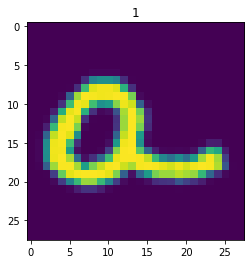

2


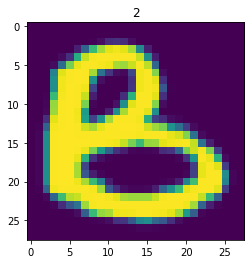

3


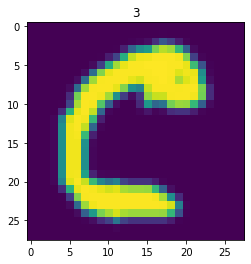

4


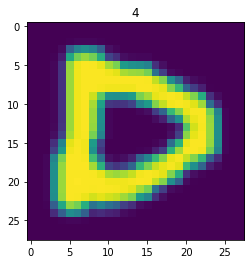

5


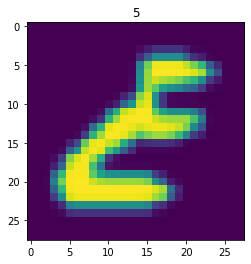

6


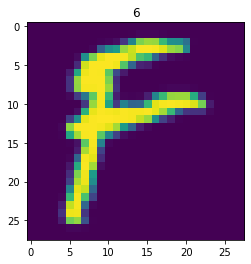

7


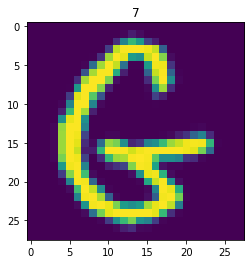

8


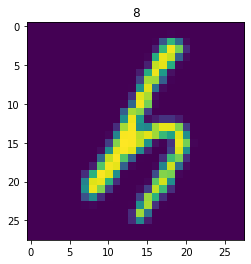

9


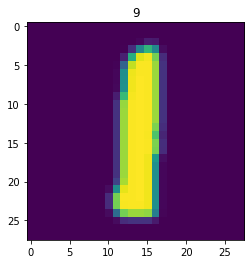

10


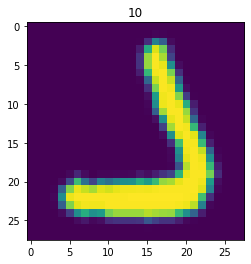

11


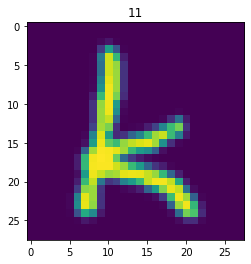

12


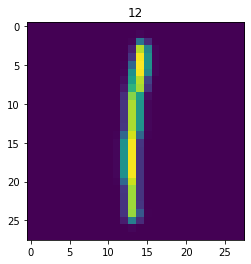

13


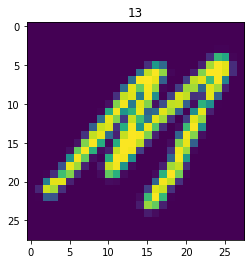

14


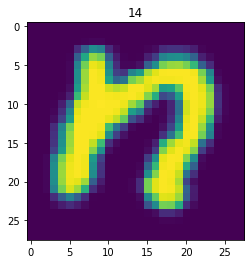

15


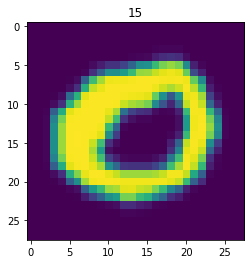

16


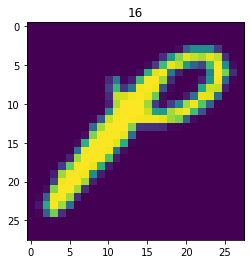

17


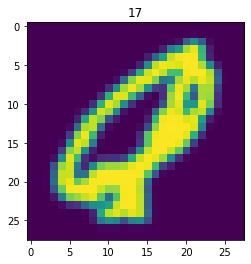

18


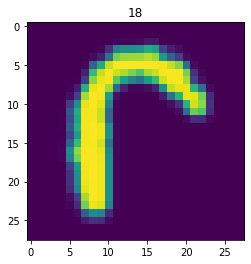

19


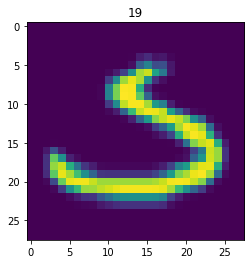

In [58]:
# EMNIST character options
df = tfds.as_dataframe(ds[1])
for label in sorted(df['label'].unique()):
    print(label)
    im = df[df['label'] == label]['image'].iloc[0]
    plt.imshow(tf.image.flip_left_right(tf.image.rot90(im, 3)))
    plt.title(label)
    plt.show()

In [5]:
# Generate smaller testing sample for csim and co-sim
test_images_sample = np.concatenate([test_images[np.where(test_labels == 1)[0][:100]], test_images[np.where(test_labels == 0)[0][:100]]])
test_labels_sample = np.concatenate([np.ones(100), np.zeros(100)]) 

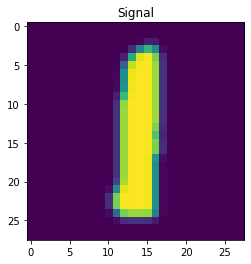

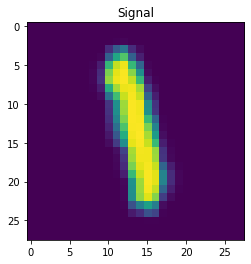

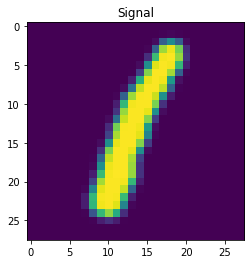

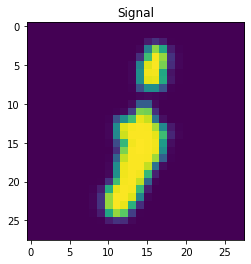

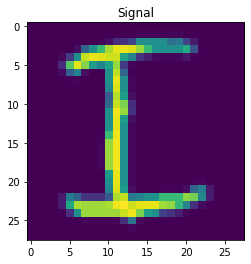

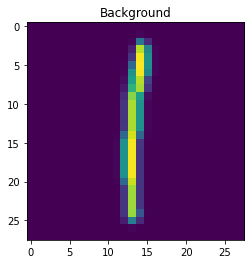

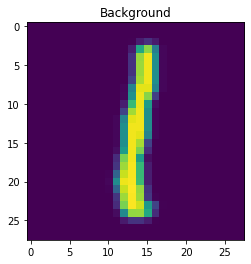

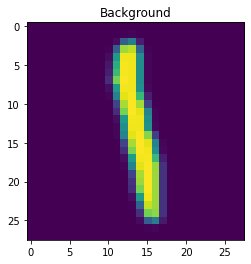

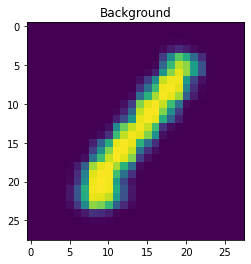

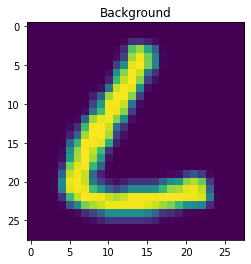

In [6]:
# Plot Signal vs Background
for im in test_images[np.where(test_labels == 1)[0]][:5]:
    plt.imshow(im)
    plt.title('Signal')
    plt.show()
    
for im in test_images[np.where(test_labels == 0)[0]][:5]:
    plt.imshow(im)
    plt.title('Background')
    plt.show()

In [6]:
# Baseline Model
baseline = keras.models.Sequential(name='Baseline')
baseline.add(keras.layers.Input((28,28,1), name='ImgInput'))
baseline.add(keras.layers.Conv2D(4, (3,3), activation='relu', name='Conv2D_0'))
baseline.add(keras.layers.MaxPooling2D((2,2), name='MaxPooling_0'))
baseline.add(keras.layers.Conv2D(4, (3,3), activation='relu', name='Conv2D_1'))
baseline.add(keras.layers.MaxPooling2D((2,2), name='MaxPooling_1'))
baseline.add(keras.layers.Flatten())
baseline.add(keras.layers.Dense(8, activation='relu', name='Dense_0'))
baseline.add(keras.layers.Dense(1, activation='sigmoid', name='Output'))
baseline = train_best_auc(baseline, train_images, train_labels, test_images, test_labels)

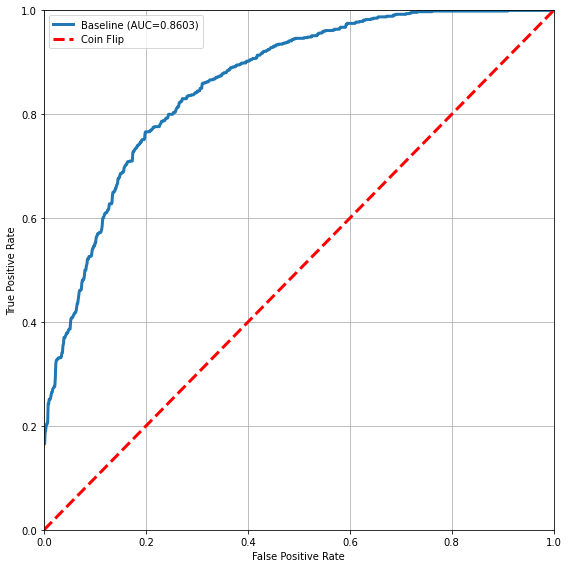

In [8]:
# Control Model ROC
roc(baseline, test_images, test_labels)

Interpreting Sequential
Topology:
Layer name: ImgInput, layer type: InputLayer, current shape: [[None, 28, 28, 1]]
Layer name: Conv2D_0, layer type: Conv2D, current shape: [[None, 28, 28, 1]]
Layer name: MaxPooling_0, layer type: MaxPooling2D, current shape: [[None, 26, 26, 4]]
Layer name: Conv2D_1, layer type: Conv2D, current shape: [[None, 13, 13, 4]]
Layer name: MaxPooling_1, layer type: MaxPooling2D, current shape: [[None, 11, 11, 4]]
Layer name: Dense_0, layer type: Dense, current shape: [[None, 5, 5, 4]]
Layer name: Output, layer type: Dense, current shape: [[None, 8]]
Creating HLS model
Writing HLS project
Done
Profiling weights
Profiling activations
   Conv2D_0
   MaxPooling_0
   Conv2D_1
   MaxPooling_1
   flatten
   Dense_0
   Output


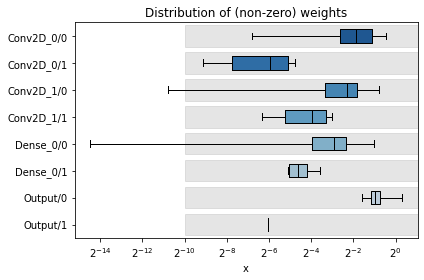

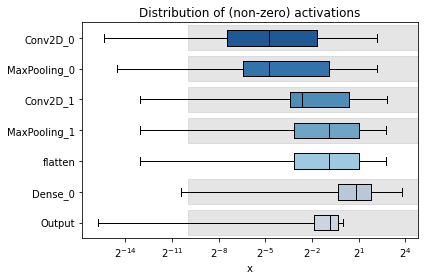

In [9]:
# Convert baseline model -- io_parallel
r = synthesize_model(baseline, 'io_parallel', 'ap_fixed<16,6>', 'Resource', 
                     show_quantization_plots=True, test_input=test_images_sample)

In [32]:
# Baseline model io_parallel synthesis results
print('Latency Clock Cycles')
display(pd.DataFrame().append(r['syn_latency_estimates'], ignore_index=True))
print('Area Estimates')
display(pd.DataFrame().append(r['reports']['syn_xml']['profile']['AreaEstimates']['Resources'], ignore_index=True))

Latency Clock Cycles


,avg,best,worst
0,24930,24530,24932


Area Estimates


,BRAM_18K,DSP48E,FF,LUT,URAM
0,192,96,69634,89629,0


In [51]:
# Quantized Models
quantized_levels = [
    ['quantized_bits(15,5)', 'quantized_relu(15,5)', 'quantized_bits_16_6'],
    ['quantized_bits(8,4)', 'quantized_relu(8,4)', 'quantized_bits_9_5'],
]

q_models = []
for q_level in quantized_levels:
    q = keras.models.Sequential(name=q_level[2])
    q.add(keras.layers.Input((28,28,1), name='ImgInput'))
    q.add(qkeras.QConv2D(4, (3,3), kernel_quantizer=q_level[0], bias_quantizer=q_level[0], name='Conv2D_0'))
    q.add(qkeras.QActivation(q_level[1], name='ReLU_0'))
    q.add(keras.layers.MaxPooling2D((2,2), name='MaxPooling_0'))
    q.add(qkeras.QConv2D(4, (3,3), kernel_quantizer=q_level[0], bias_quantizer=q_level[0], name='Conv2D_1'))
    q.add(qkeras.QActivation(q_level[1], name='ReLU_1'))
    q.add(keras.layers.MaxPooling2D((2,2), name='MaxPooling_1'))
    q.add(keras.layers.Flatten())
    q.add(qkeras.QDense(8, kernel_quantizer=q_level[0], bias_quantizer=q_level[0], name='Dense_0'))
    q.add(qkeras.QActivation(q_level[1], name='ReLU_2'))
    q.add(qkeras.QDense(1, kernel_quantizer=q_level[0], bias_quantizer=q_level[0], activation='sigmoid', name='Output'))
    q = train_best_auc(q, train_images, train_labels, test_images, test_labels, skip_reload=True)
    q_models.append(q)

Epoch 1/10
214/214 [==============================] - 4s 18ms/step - loss: 0.6362 - binary_accuracy: 0.6373 - auc_40: 0.7053 - val_loss: 0.5538 - val_binary_accuracy: 0.7250 - val_auc_40: 0.8012
Epoch 2/10
214/214 [==============================] - 3s 12ms/step - loss: 0.5325 - binary_accuracy: 0.7250 - auc_40: 0.8031 - val_loss: 0.5110 - val_binary_accuracy: 0.7519 - val_auc_40: 0.8250
Epoch 3/10
214/214 [==============================] - 2s 11ms/step - loss: 0.5074 - binary_accuracy: 0.7437 - auc_40: 0.8238 - val_loss: 0.4950 - val_binary_accuracy: 0.7606 - val_auc_40: 0.8359
Epoch 4/10
214/214 [==============================] - 2s 11ms/step - loss: 0.4956 - binary_accuracy: 0.7504 - auc_40: 0.8326 - val_loss: 0.4902 - val_binary_accuracy: 0.7600 - val_auc_40: 0.8390
Epoch 5/10
214/214 [==============================] - 2s 11ms/step - loss: 0.4877 - binary_accuracy: 0.7554 - auc_40: 0.8377 - val_loss: 0.4851 - val_binary_accuracy: 0.7600 - val_auc_40: 0.8436
Epoch 6/10
214/214 [=====

214/214 [==============================] - 3s 14ms/step - loss: 0.5858 - binary_accuracy: 0.6700 - auc_48: 0.7474 - val_loss: 0.5242 - val_binary_accuracy: 0.7381 - val_auc_48: 0.8164
Epoch 2/10
214/214 [==============================] - 2s 11ms/step - loss: 0.5129 - binary_accuracy: 0.7409 - auc_48: 0.8199 - val_loss: 0.4944 - val_binary_accuracy: 0.7481 - val_auc_48: 0.8367
Epoch 3/10
214/214 [==============================] - 2s 10ms/step - loss: 0.4897 - binary_accuracy: 0.7552 - auc_48: 0.8375 - val_loss: 0.4831 - val_binary_accuracy: 0.7631 - val_auc_48: 0.8457
Epoch 4/10
214/214 [==============================] - 2s 10ms/step - loss: 0.4797 - binary_accuracy: 0.7631 - auc_48: 0.8447 - val_loss: 0.4763 - val_binary_accuracy: 0.7700 - val_auc_48: 0.8477
Epoch 5/10
214/214 [==============================] - 2s 10ms/step - loss: 0.4723 - binary_accuracy: 0.7633 - auc_48: 0.8492 - val_loss: 0.4766 - val_binary_accuracy: 0.7663 - val_auc_48: 0.8463
Epoch 6/10
214/214 [================

214/214 [==============================] - 3s 16ms/step - loss: 0.6199 - binary_accuracy: 0.6352 - auc_56: 0.7008 - val_loss: 0.5361 - val_binary_accuracy: 0.7331 - val_auc_56: 0.8092
Epoch 2/10
214/214 [==============================] - 2s 11ms/step - loss: 0.5220 - binary_accuracy: 0.7340 - auc_56: 0.8126 - val_loss: 0.4949 - val_binary_accuracy: 0.7600 - val_auc_56: 0.8379
Epoch 3/10
214/214 [==============================] - 2s 10ms/step - loss: 0.4964 - binary_accuracy: 0.7555 - auc_56: 0.8308 - val_loss: 0.4777 - val_binary_accuracy: 0.7650 - val_auc_56: 0.8464
Epoch 4/10
214/214 [==============================] - 2s 11ms/step - loss: 0.4811 - binary_accuracy: 0.7621 - auc_56: 0.8424 - val_loss: 0.4732 - val_binary_accuracy: 0.7725 - val_auc_56: 0.8517
Epoch 5/10
214/214 [==============================] - 2s 11ms/step - loss: 0.4719 - binary_accuracy: 0.7706 - auc_56: 0.8490 - val_loss: 0.4677 - val_binary_accuracy: 0.7706 - val_auc_56: 0.8542
Epoch 6/10
214/214 [================

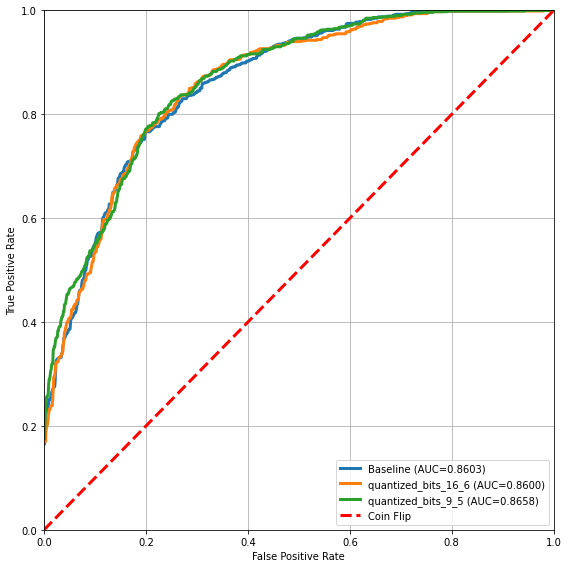

In [52]:
# Quantized Model Comparison
roc([baseline] + q_models, test_images, test_labels)

In [35]:
# TWN Model
twn = keras.models.Sequential(name='TernaryWeights')
twn.add(keras.layers.Input((28,28,1), name='ImgInput'))
twn.add(qkeras.QConv2D(4, (3,3), kernel_quantizer='stochastic_ternary', bias_quantizer='quantized_bits(8,4)', activation='quantized_relu(8,4)', name='Conv2D_0'))
twn.add(keras.layers.MaxPooling2D((2,2), name='MaxPooling_0'))
twn.add(qkeras.QConv2D(4, (3,3), kernel_quantizer='stochastic_ternary', bias_quantizer='quantized_bits(8,4)', activation='quantized_relu(8,4)', name='Conv2D_1'))
twn.add(keras.layers.MaxPooling2D((2,2), name='MaxPooling_1'))
twn.add(keras.layers.Flatten())
twn.add(qkeras.QDense(8, kernel_quantizer='stochastic_ternary', bias_quantizer='quantized_relu(8,4)', activation='quantized_relu(8,4)', name='Dense_0'))
twn.add(qkeras.QDense(1, kernel_quantizer='quantized_relu(8,4)', bias_quantizer='quantized_relu(8,4)', activation='smooth_sigmoid', name='Output'))
twn = train_best_auc(twn, train_images, train_labels, test_images, test_labels)

Epoch 1/10
214/214 [==============================] - 3s 15ms/step - loss: 0.6731 - binary_accuracy: 0.5518 - auc_30: 0.7162 - val_loss: 0.6714 - val_binary_accuracy: 0.5056 - val_auc_30: 0.7924
Epoch 2/10
214/214 [==============================] - 2s 11ms/step - loss: 0.6622 - binary_accuracy: 0.5978 - auc_30: 0.7326 - val_loss: 0.6720 - val_binary_accuracy: 0.5962 - val_auc_30: 0.7780
Epoch 3/10
214/214 [==============================] - 2s 11ms/step - loss: 0.6438 - binary_accuracy: 0.6426 - auc_30: 0.7728 - val_loss: 0.6476 - val_binary_accuracy: 0.7169 - val_auc_30: 0.7641
Epoch 4/10
214/214 [==============================] - 2s 11ms/step - loss: 0.6369 - binary_accuracy: 0.6738 - auc_30: 0.7696 - val_loss: 0.6170 - val_binary_accuracy: 0.6569 - val_auc_30: 0.8043
Epoch 5/10
214/214 [==============================] - 2s 11ms/step - loss: 0.6303 - binary_accuracy: 0.6782 - auc_30: 0.7828 - val_loss: 0.6221 - val_binary_accuracy: 0.6206 - val_auc_30: 0.8115
Epoch 6/10
214/214 [=====

Epoch 2/10
214/214 [==============================] - 3s 13ms/step - loss: 0.6562 - binary_accuracy: 0.6217 - auc_38: 0.7520 - val_loss: 0.6446 - val_binary_accuracy: 0.7219 - val_auc_38: 0.7807
Epoch 3/10
214/214 [==============================] - 3s 13ms/step - loss: 0.6496 - binary_accuracy: 0.6561 - auc_38: 0.7161 - val_loss: 0.6313 - val_binary_accuracy: 0.7244 - val_auc_38: 0.7638
Epoch 4/10
214/214 [==============================] - 3s 12ms/step - loss: 0.6358 - binary_accuracy: 0.6775 - auc_38: 0.7574 - val_loss: 0.6218 - val_binary_accuracy: 0.6762 - val_auc_38: 0.7969
Epoch 5/10
214/214 [==============================] - 3s 12ms/step - loss: 0.6337 - binary_accuracy: 0.6789 - auc_38: 0.7717 - val_loss: 0.6210 - val_binary_accuracy: 0.6694 - val_auc_38: 0.8038
Epoch 6/10
214/214 [==============================] - 3s 12ms/step - loss: 0.6288 - binary_accuracy: 0.6909 - auc_38: 0.7697 - val_loss: 0.6288 - val_binary_accuracy: 0.6419 - val_auc_38: 0.8207
Epoch 7/10
214/214 [=====

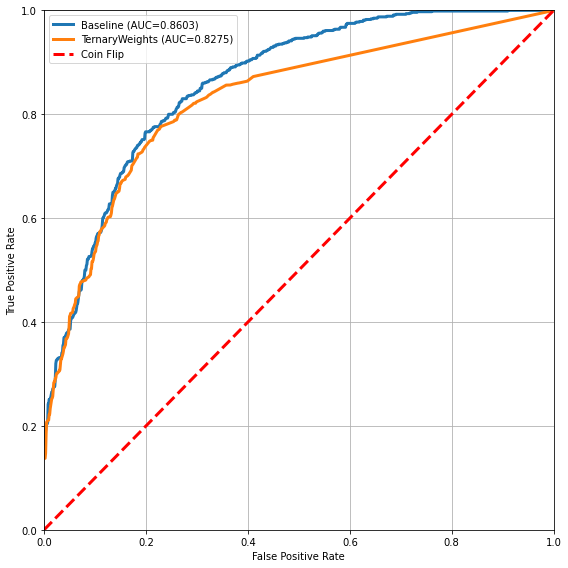

In [37]:
# TWN Model ROC
roc([baseline, twn], test_images, test_labels)

In [13]:
# Deployment Optimized Model
q_dom = keras.models.Sequential(name='DeploymentOptimized')
q_dom.add(keras.layers.Input((28,28,1), name='ImgInput'))
q_dom.add(qkeras.QConv2D(4, (3,3), kernel_quantizer='quantized_bits(8,4)', bias_quantizer='quantized_bits(8,4)', name='Conv2D_0'))
q_dom.add(qkeras.QActivation('quantized_relu(8,4)', name='ReLU_0'))
q_dom.add(keras.layers.MaxPooling2D((2,2), name='MaxPooling_0'))
q_dom.add(keras.layers.SeparableConv2D(4, (3,3), name='SeparableConv2D_0'))
# q_dom.add(qkeras.QDepthwiseConv2D((3,3), depthwise_quantizer='quantized_bits(8,4)', use_bias=False, name='DepthwiseConv2D_0'))
# q_dom.add(qkeras.QConv2D(4, (1,1), kernel_quantizer='quantized_bits(8,4)', bias_quantizer='quantized_bits(8,4)', name='PointwiseConv2D_0'))
q_dom.add(qkeras.QActivation('quantized_relu(8,4)', name='ReLU_1'))
q_dom.add(keras.layers.MaxPooling2D((2,2), name='MaxPooling_1'))
q_dom.add(keras.layers.Flatten(name='Flatten'))
q_dom.add(qkeras.QDense(8, kernel_quantizer='quantized_bits(8,4)', bias_quantizer='quantized_bits(8,4)', name='Dense_0'))
q_dom.add(qkeras.QActivation('quantized_relu(8,4)', name='ReLU_2'))
q_dom.add(qkeras.QDense(1, kernel_quantizer='quantized_bits(8,4)', bias_quantizer='quantized_bits(8,4)', activation='sigmoid', name='Output'))
q_dom = train_best_auc(q_dom, train_images, train_labels, test_images, test_labels, skip_reload=True)

Epoch 1/10
214/214 [==============================] - 3s 15ms/step - loss: 0.6303 - binary_accuracy: 0.6309 - auc_10: 0.6922 - val_loss: 0.5628 - val_binary_accuracy: 0.7131 - val_auc_10: 0.7797
Epoch 2/10
214/214 [==============================] - 2s 11ms/step - loss: 0.5354 - binary_accuracy: 0.7218 - auc_10: 0.8006 - val_loss: 0.5117 - val_binary_accuracy: 0.7544 - val_auc_10: 0.8253
Epoch 3/10
214/214 [==============================] - 3s 12ms/step - loss: 0.5104 - binary_accuracy: 0.7410 - auc_10: 0.8217 - val_loss: 0.5038 - val_binary_accuracy: 0.7475 - val_auc_10: 0.8313
Epoch 4/10
214/214 [==============================] - 3s 12ms/step - loss: 0.4954 - binary_accuracy: 0.7472 - auc_10: 0.8324 - val_loss: 0.4955 - val_binary_accuracy: 0.7544 - val_auc_10: 0.8356
Epoch 5/10
214/214 [==============================] - 3s 12ms/step - loss: 0.4891 - binary_accuracy: 0.7516 - auc_10: 0.8361 - val_loss: 0.4864 - val_binary_accuracy: 0.7569 - val_auc_10: 0.8418
Epoch 6/10
214/214 [=====

214/214 [==============================] - 3s 14ms/step - loss: 0.6356 - binary_accuracy: 0.6126 - auc_14: 0.6756 - val_loss: 0.5638 - val_binary_accuracy: 0.6981 - val_auc_14: 0.7850
Epoch 2/10
214/214 [==============================] - 2s 11ms/step - loss: 0.5532 - binary_accuracy: 0.7035 - auc_14: 0.7799 - val_loss: 0.5235 - val_binary_accuracy: 0.7325 - val_auc_14: 0.8152
Epoch 3/10
214/214 [==============================] - 2s 11ms/step - loss: 0.5298 - binary_accuracy: 0.7245 - auc_14: 0.8028 - val_loss: 0.5087 - val_binary_accuracy: 0.7494 - val_auc_14: 0.8286
Epoch 4/10
214/214 [==============================] - 2s 11ms/step - loss: 0.5132 - binary_accuracy: 0.7354 - auc_14: 0.8181 - val_loss: 0.5066 - val_binary_accuracy: 0.7425 - val_auc_14: 0.8346
Epoch 5/10
214/214 [==============================] - 2s 11ms/step - loss: 0.5002 - binary_accuracy: 0.7517 - auc_14: 0.8287 - val_loss: 0.4871 - val_binary_accuracy: 0.7525 - val_auc_14: 0.8424
Epoch 6/10
214/214 [================

214/214 [==============================] - 3s 14ms/step - loss: 0.6197 - binary_accuracy: 0.6240 - auc_18: 0.6921 - val_loss: 0.5447 - val_binary_accuracy: 0.7281 - val_auc_18: 0.8028
Epoch 2/10
214/214 [==============================] - 2s 11ms/step - loss: 0.5258 - binary_accuracy: 0.7291 - auc_18: 0.8056 - val_loss: 0.5012 - val_binary_accuracy: 0.7506 - val_auc_18: 0.8307
Epoch 3/10
214/214 [==============================] - 2s 11ms/step - loss: 0.5010 - binary_accuracy: 0.7495 - auc_18: 0.8274 - val_loss: 0.4911 - val_binary_accuracy: 0.7538 - val_auc_18: 0.8371
Epoch 4/10
214/214 [==============================] - 2s 11ms/step - loss: 0.4905 - binary_accuracy: 0.7576 - auc_18: 0.8364 - val_loss: 0.4932 - val_binary_accuracy: 0.7475 - val_auc_18: 0.8402
Epoch 5/10
214/214 [==============================] - 2s 11ms/step - loss: 0.4840 - binary_accuracy: 0.7612 - auc_18: 0.8403 - val_loss: 0.4804 - val_binary_accuracy: 0.7619 - val_auc_18: 0.8456
Epoch 6/10
214/214 [================

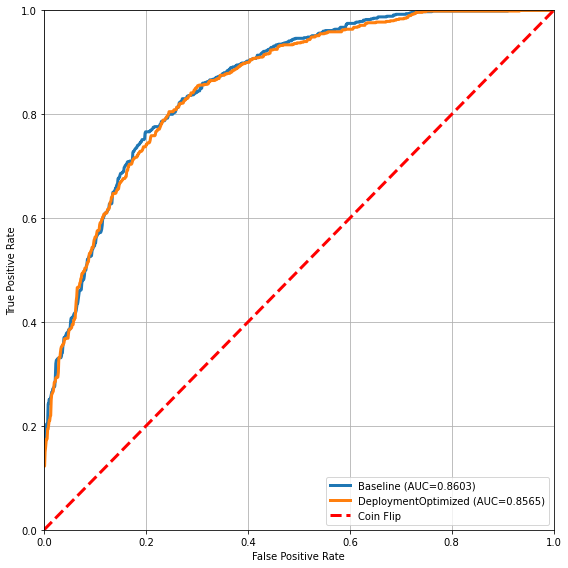

In [14]:
# Deployment Optimized ROC
roc([baseline, q_dom], test_images, test_labels)

In [10]:
# Export Deployment Optimized Model (because of QDepthwiseConv2D layer)
e_dom = keras.models.Sequential(name='DeploymentOptimizedExport')
e_dom.add(keras.layers.Input((28,28,1), name='ImgInput'))
e_dom.add(keras.layers.Conv2D(4, (3,3), name='Conv2D_0'))
e_dom.add(keras.layers.Activation('relu', name='ReLU_0'))
e_dom.add(keras.layers.MaxPooling2D((2,2), name='MaxPooling_0'))
e_dom.add(keras.layers.DepthwiseConv2D((3,3), use_bias=False, name='DepthwiseConv2D_0'))
e_dom.add(keras.layers.Conv2D(4, (1,1), name='PointwiseConv2D_0'))
e_dom.add(keras.layers.Activation('relu', name='ReLU_1'))
e_dom.add(keras.layers.MaxPooling2D((2,2), name='MaxPooling_1'))
e_dom.add(keras.layers.Flatten(name='Flatten'))
e_dom.add(keras.layers.Dense(8, name='Dense_0'))
e_dom.add(keras.layers.Activation('relu', name='ReLU_2'))
e_dom.add(keras.layers.Dense(1, activation='sigmoid', name='Output'))

for layer in e_dom.layers:
    layer.set_weights(q_dom.get_layer(layer.name).get_weights())


In [31]:
# Synthesize Deployment Optimized Model
r = synthesize_model(baseline, 'io_stream', 'ap_fixed<16,6>', 'Latency', csim=True, cosim=True, validate_sim_results=True,
                     show_quantization_plots=False, test_input=test_images_sample, test_truth=test_labels_sample)

Interpreting Sequential
Topology:
Layer name: ImgInput, layer type: InputLayer, current shape: [[None, 28, 28, 1]]
Layer name: Conv2D_0, layer type: Conv2D, current shape: [[None, 28, 28, 1]]
Layer name: MaxPooling_0, layer type: MaxPooling2D, current shape: [[None, 26, 26, 4]]
Layer name: Conv2D_1, layer type: Conv2D, current shape: [[None, 13, 13, 4]]
Layer name: MaxPooling_1, layer type: MaxPooling2D, current shape: [[None, 11, 11, 4]]
Layer name: Dense_0, layer type: Dense, current shape: [[None, 5, 5, 4]]
Layer name: Output, layer type: Dense, current shape: [[None, 8]]
Creating HLS model
Writing HLS project
Done
--------------------------------------------------
Baseline CSIM Metrics
binary accuracy = 0.77
AUC = 0.8568
--------------------------------------------------
--------------------------------------------------
Baseline CO-SIM Metrics
binary accuracy = 0.77
AUC = 0.8568
--------------------------------------------------


In [30]:
# Quantized model io_stream synthesis results
print('Latency Clock Cycles')
display(pd.DataFrame().append(r['syn_latency_estimates'], ignore_index=True))
print('Simulation Results')
display(pd.DataFrame().append(r['reports']['sim_rpt'], ignore_index=True))
print('Area Estimates')
display(pd.DataFrame().append(r['reports']['syn_xml']['profile']['AreaEstimates']['Resources'], ignore_index=True))

Latency Clock Cycles


,avg,best,worst
0,1582,1582,1582


Simulation Results


,AVER_LATENCY,AVER_THROUGHPUT,MAX_LATENCY,MAX_THROUGHPUT,MIN_LATENCY,MIN_THROUGHPUT
0,4541.0,2271.0,4542.0,2272.0,4522.0,2252.0


Area Estimates


,BRAM_18K,DSP48E,FF,LUT,URAM
0,73,449,32029,48546,0


In [23]:
softmax_labels_test = np.array([[1,0] if x == 1 else [0,1] for x in test_labels])
softmax_labels_train = np.array([[1,0] if x == 1 else [0,1] for x in train_labels])

In [25]:
# test Model

test = keras.models.Sequential(name='Test')
test.add(keras.layers.Input((28,28,1), name='ImgInput'))
test.add(keras.layers.Conv2D(4, (3,3), activation='relu', name='Conv2D_0'))
test.add(keras.layers.MaxPooling2D((2,2), name='MaxPooling_0'))
test.add(keras.layers.Conv2D(4, (3,3), activation='relu', name='Conv2D_1'))
test.add(keras.layers.MaxPooling2D((2,2), name='MaxPooling_1'))
test.add(keras.layers.Flatten())
test.add(keras.layers.Dense(8, activation='relu', name='Dense_0'))
test.add(keras.layers.Dense(2, activation='softmax', name='Output'))
test.compile(optimizer='Nadam', loss=keras.losses.categorical_crossentropy, metrics=[keras.metrics.CategoricalAccuracy()])
test.fit(train_images, softmax_labels_train, epochs=10, validation_data=(test_images, softmax_labels_test))

Epoch 1/10
214/214 [==============================] - 2s 8ms/step - loss: 0.6175 - categorical_accuracy: 0.6386 - val_loss: 0.5433 - val_categorical_accuracy: 0.7156
Epoch 2/10
214/214 [==============================] - 2s 8ms/step - loss: 0.5377 - categorical_accuracy: 0.7136 - val_loss: 0.5174 - val_categorical_accuracy: 0.7412
Epoch 3/10
214/214 [==============================] - 2s 7ms/step - loss: 0.5185 - categorical_accuracy: 0.7349 - val_loss: 0.5021 - val_categorical_accuracy: 0.7606
Epoch 4/10
214/214 [==============================] - 2s 7ms/step - loss: 0.5062 - categorical_accuracy: 0.7432 - val_loss: 0.4956 - val_categorical_accuracy: 0.7606
Epoch 5/10
214/214 [==============================] - 1s 7ms/step - loss: 0.4958 - categorical_accuracy: 0.7500 - val_loss: 0.4857 - val_categorical_accuracy: 0.7769
Epoch 6/10
214/214 [==============================] - 1s 7ms/step - loss: 0.4878 - categorical_accuracy: 0.7573 - val_loss: 0.4850 - val_categorical_accuracy: 0.7738
Epoc

In [28]:
r = synthesize_model(test, 'io_stream', 'ap_fixed<16,6>', 'Latency', csim=True, validate_sim_results=True, test_input=test_images_sample, 
                     test_truth=test_labels_sample)

Interpreting Sequential
Topology:
Layer name: ImgInput, layer type: InputLayer, current shape: [[None, 28, 28, 1]]
Layer name: Conv2D_0, layer type: Conv2D, current shape: [[None, 28, 28, 1]]
Layer name: MaxPooling_0, layer type: MaxPooling2D, current shape: [[None, 26, 26, 4]]
Layer name: Conv2D_1, layer type: Conv2D, current shape: [[None, 13, 13, 4]]
Layer name: MaxPooling_1, layer type: MaxPooling2D, current shape: [[None, 11, 11, 4]]
Layer name: Dense_0, layer type: Dense, current shape: [[None, 5, 5, 4]]
Layer name: Output, layer type: Dense, current shape: [[None, 8]]
Creating HLS model
Writing HLS project
Done


ValueError: could not convert string to float: '0.572266 0.445313 '